In [49]:
import pandas as pd
from fep import FEP, load_features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score

In [6]:
def svm_model_evaluation(df):
    X = df.drop(columns=['outcome'])  
    y = df['outcome']                

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    svm_model = SVC(kernel='linear', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)

    # Model evaluation
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]

    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm_model.classes_)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_proba)
    print("ROC AUC Score:", auc_score)


In [17]:
def random_forest(df):
    X = df.drop(columns=['outcome'])  
    y = df['outcome']                


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    dt_model = RandomForestClassifier(n_estimators=5)
    dt_model.fit(X_train, y_train)


    importances = dt_model.feature_importances_
    feature_names = X.columns


    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance in Decision Tree")
    plt.show()


    y_pred = dt_model.predict(X_test)


    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_model.classes_)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(y_test,y_pred))
    y_proba = dt_model.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_proba)
    print("ROC AUC Score:", auc_score)

In [7]:
# import data
bids = pd.read_csv('../Data/facebook/bids.csv')
bidder = pd.read_csv('../Data/facebook/train.csv')

In [8]:
# fill contry with the mode.
bids['country'].fillna(bids['country'].mode()[0], inplace = True)   

In [9]:
# encoding 
unique_bidders = pd.concat([bids['bidder_id'], bidder['bidder_id']]).unique()
bidder_mapping = {bidder_id: idx for idx, bidder_id in enumerate(unique_bidders)}
bids['encoded_bidder_id'] = bids['bidder_id'].map(bidder_mapping)
bidder['encoded_bidder_id'] = bidder['bidder_id'].map(bidder_mapping)
bids.drop('bidder_id', axis=1, inplace=True)
bidder.drop('bidder_id', axis=1, inplace=True)

# drop useless bidder features
bidder.drop(['payment_account', 'address'], axis=1, inplace=True)

In [10]:
# extract and merge count features
count_for_bidder = bids.groupby("encoded_bidder_id").nunique()
df_train_bidder = pd.merge(bidder, count_for_bidder, on='encoded_bidder_id', how='left') # drop the right 
df_train_bidder = df_train_bidder.rename(columns = {'bid_id': 'N_bids', 'auction': 'N_auctions', 'merchandise': 'N_merchandise', 'device': 'N_device', 'time': 'N_time', 'country': 'N_country', 'ip': 'N_ip', 'url': 'N_url'})

In [11]:
# extract number of bids for something
df_train_bidder['bids/url'] = df_train_bidder['N_bids'] / df_train_bidder['N_url']
df_train_bidder['bids/ip'] = df_train_bidder['N_bids'] / df_train_bidder['N_ip']
df_train_bidder['bids/auctions'] = df_train_bidder['N_bids'] / df_train_bidder['N_auctions']
df_train_bidder['bids/country'] = df_train_bidder['N_bids'] / df_train_bidder['N_country']
df_train_bidder['bids/device'] = df_train_bidder['N_bids'] / df_train_bidder['N_device']
df_train_bidder = df_train_bidder.fillna(0) # fill NaN with 0 for bidders that never placed a bid

In [12]:
df_time = bids.drop(['bid_id', 'country', 'merchandise', 'device', 'url', 'ip', 'auction'],axis=1, inplace=False)
temp = df_time.copy()
df_time['difference'] = temp.groupby('encoded_bidder_id').diff() 
# we can drop NaN that are the first bid of each bidder
df_time.dropna(inplace = True)

count_concurrent_bids = df_time[df_time['difference']==0].groupby('encoded_bidder_id').count().drop('time', axis=1)
count_concurrent_bids.rename(columns = {'difference': 'count_concurrent_bids'}, inplace=True)
df_train_bidder = pd.merge(df_train_bidder, count_concurrent_bids, on='encoded_bidder_id', how='left').fillna(0)

temp = df_time.groupby('encoded_bidder_id')['difference'].describe()
temp.drop(['count'], axis=1, inplace=True)
temp.rename(columns = {'mean': 'mean_difference', 'std': 'std_difference', 'min': 'min_difference', 'max':'max_difference', '50%':'median_difference', '25%':'25_difference', '75%':'75_difference'}, inplace=True)
temp['iqrDiff'] = temp['75_difference']-temp['25_difference']
df_train_bidder = pd.merge(df_train_bidder, temp, on='encoded_bidder_id', how='left').fillna(0)

In [13]:
temp_df = bids.sort_values(['auction', 'time'])
winner_bids = temp_df.groupby('auction').max('time')
count_win = winner_bids.groupby('encoded_bidder_id').count().drop('time',axis=1, inplace=False).rename(columns = {'bid_id': 'N_win'})
df_train_bidder = pd.merge(df_train_bidder, count_win, on='encoded_bidder_id', how='left').fillna(0)

In [14]:
temp_df = bids.sort_values(['auction', 'time'])
temp_df = temp_df.drop(['bid_id','merchandise','device','country','ip','url'],axis=1, inplace=False)

auct_duration = bids.sort_values(['auction', 'time'])[['encoded_bidder_id', 'auction', 'time']]
auct_duration = auct_duration[['auction', 'time']].groupby('auction').quantile(0.75).reset_index()
auct_duration.rename(columns={'time': 'q75'}, inplace=True)

temp_df = temp_df.merge(auct_duration, on='auction')
temp_df.fillna(0)
bidder_q75_counts = temp_df.groupby('encoded_bidder_id').apply(lambda x: (x['time'] > x['q75']).sum()).reset_index(name='q75_bid_count')
df_train_bidder = pd.merge(df_train_bidder, bidder_q75_counts, on='encoded_bidder_id', how='left').fillna(0)

In [82]:
df = df_train_bidder.drop(['encoded_bidder_id'],axis=1,inplace=False)

In [83]:
df.columns

Index(['outcome', 'N_bids', 'N_auctions', 'N_merchandise', 'N_device',
       'N_time', 'N_country', 'N_ip', 'N_url', 'bids/url', 'bids/ip',
       'bids/auctions', 'bids/country', 'bids/device', 'count_concurrent_bids',
       'mean_difference', 'std_difference', 'min_difference', '25_difference',
       'median_difference', '75_difference', 'max_difference', 'iqrDiff',
       'N_win', 'q75_bid_count'],
      dtype='object')

In [81]:
# here fro pre-drop

### Feature selection

In [185]:
X, y = df.drop(columns=['outcome']), df['outcome']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=42)

n_features = X.shape[1]

best_model = None
best_score = 0
best_features = []


all_features = list(range(n_features))


while n_features > 0:
    best = 0
    best_feature = None
    selected_features = best_features.copy()  # Mantieni le migliori feature selezionate fino a quel punto

    for feature in all_features:
        if feature not in selected_features:
            current_features = selected_features + [feature]
            model = RandomForestClassifier(n_estimators=5, random_state=42)
            
            model.fit(X_train.iloc[:, current_features], y_train)
            y_pred = model.predict(X_validation.iloc[:, current_features])    

            # max recall
            #score = recall_score(y_validation, y_pred, average='weighted')

            # max auc score
            y_probs = model.predict_proba(X_validation.iloc[:, current_features])
            score = roc_auc_score(y_validation, y_probs[:, 1])

            # max f1
            #score = f1_score(y_validation, y_pred, average='weighted')

            if score > best:
                best = score
                best_feature = feature

    if best_feature is not None:
        best_features.append(best_feature)
        if best > best_score:
            best_score = best
            best_model = best_features.copy()  

    n_features -= 1  

print(f"Selected Features Index: {best_model}, score: {best_score}")
print(f"len: {len(best_model)}")


Selected Features Index: [16, 2, 12, 4, 7, 20, 22, 8, 19, 0, 15, 3, 18, 5, 6, 23, 11, 17, 1, 14, 9], score: 0.8990628410039155
len: 21


In [186]:
selected_feature_names = X.columns[best_model]

print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['min_difference', 'N_merchandise', 'bids/device', 'N_time', 'N_url',
       'max_difference', 'N_win', 'bids/url', '75_difference', 'N_bids',
       'std_difference', 'N_device', 'median_difference', 'N_country', 'N_ip',
       'q75_bid_count', 'bids/country', '25_difference', 'N_auctions',
       'mean_difference', 'bids/ip'],
      dtype='object')


### Oversampling SMOTE

In [187]:
X_train_selected = X_train.iloc[:, best_model]
X_validation_selected = X_validation.iloc[:, best_model]

In [188]:
from imblearn.over_sampling import SMOTE

# Applica SMOTE per bilanciare il dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train)

# Verifica il nuovo bilanciamento delle classi
print("Distribuzione dopo SMOTE:", pd.Series(y_resampled).value_counts())

Distribuzione dopo SMOTE: outcome
0.0    1333
1.0    1333
Name: count, dtype: int64


### Model validation

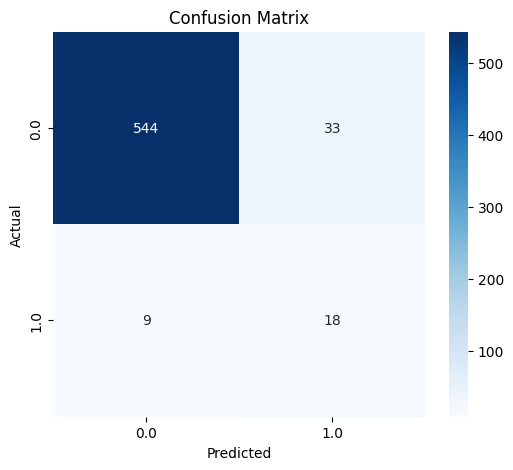

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       577
         1.0       0.35      0.67      0.46        27

    accuracy                           0.93       604
   macro avg       0.67      0.80      0.71       604
weighted avg       0.96      0.93      0.94       604



In [179]:
final_model = RandomForestClassifier(n_estimators=7, random_state=42)
final_model.fit(X_resampled, y_resampled)

y_pred = final_model.predict(X_validation_selected)

cm = confusion_matrix(y_validation, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_validation, y_pred))

In [189]:
y_probs = final_model.predict_proba(X_validation_selected)
roc_auc = roc_auc_score(y_validation, y_probs[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8934
